In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from pycirclize import Circos
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
import sklearn
sklearn.__version__

'1.5.2'

In [3]:
# load ann data
resolution = 1000000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()

# sort the object by global bin id
sorted_indices = adata.obs['bin'].argsort()
adata = adata[sorted_indices, :] 

adata

Time taken to read the file: 10.58 seconds
Memory usage: current 1.53 GB, difference +1.53 GB


View of AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

In [4]:
adata.uns['chrom_sizes']['n_bins'] = adata.uns['chrom_sizes']['size'] // adata.uns['base_resolution']
adata.uns['chrom_sizes'].head()

,chrom,size,bp_start,n_bins
0,1,195154279,0,195
1,2,181755017,195154279,181
2,3,159745316,376909296,159
3,4,156860686,536654612,156
4,5,151758149,693515298,151


In [5]:
adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ATACSeq_3,CTCF,H3K27ac,H3K27me3,RNA_1,RNA_2,RNA_3,RNA_4,RNA_5,RNA_6
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.375103,0.319337,0.211256,0.577305,0.263153,0.203017,0.128587,0.271721,0.124134,0.093115
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.586783,0.561063,0.698206,0.735207,0.282745,0.706667,0.265677,0.247106,0.684904,0.225147
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.467917,0.426098,0.410865,0.458616,0.197587,0.273313,0.233012,0.157297,0.282102,0.108284
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.493767,0.474813,0.412592,0.640384,0.209920,0.285676,0.147348,0.170128,0.248226,0.116792
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.427530,0.387846,0.458324,0.391387,0.229293,0.227452,0.157668,0.166332,0.212388,0.116124


In [6]:
def find_outliers(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers(adata.obs['degree'])

print(adata.obs['degree_outlier'].value_counts())

# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()

print('done!')

degree_outlier
False    2431
True      148
Name: count, dtype: int64
Removing top 148 outlier loci: 
['chr1:24', 'chr1:85', 'chr1:195', 'chr2:98', 'chr2:177', 'chr4:112', 'chr4:145', 'chr4:146', 'chr4:147', 'chr5:94', 'chr5:95', 'chr6:103', 'chr7:20', 'chr7:21', 'chr7:22', 'chr7:32', 'chr8:19', 'chr8:20', 'chr8:21', 'chr8:70', 'chr8:130', 'chr9:3', 'chr9:35', 'chr9:124', 'chr10:130', 'chr11:3', 'chr12:3', 'chr13:65', 'chr13:66', 'chr14:3', 'chr14:15', 'chr14:16', 'chr14:17', 'chr14:18', 'chr14:19', 'chr14:125', 'chr16:3', 'chr17:95', 'chr19:61', 'chrX:6', 'chrX:8', 'chrX:9', 'chrX:10', 'chrX:14', 'chrX:15', 'chrX:16', 'chrX:17', 'chrX:18', 'chrX:19', 'chrX:22', 'chrX:23', 'chrX:24', 'chrX:25', 'chrX:26', 'chrX:27', 'chrX:29', 'chrX:34', 'chrX:38', 'chrX:39', 'chrX:40', 'chrX:42', 'chrX:43', 'chrX:44', 'chrX:45', 'chrX:46', 'chrX:48', 'chrX:49', 'chrX:53', 'chrX:54', 'chrX:57', 'chrX:58', 'chrX:60', 'chrX:61', 'chrX:62', 'chrX:63', 'chrX:64', 'chrX:65', 'chrX:66', 'chrX:67', 'chrX:68', 

# Load the core scores 

In [7]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_1000000_scores.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

columns_to_drop = [x for x in df.columns if x in adata.obs.columns]
df = df.drop(columns=columns_to_drop)
print(f"{df.shape=}")
df.head()


df.shape=(2431, 36)
df.shape=(2431, 14)


,bin_name,chrom_degree,ce_singular_vector_1,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,1200.0,0.118719,0.118720,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,1392.0,0.352755,0.352756,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1406.0,0.218332,0.218333,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1564.0,0.528992,0.528993,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,1441.0,0.083651,0.083653,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


In [8]:
adata.obs = pd.merge(
    adata.obs, df.set_index('bin_name'),
    how='left',
    left_index=True,
    right_index=True,
)

adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# How similar are chromosome and glovel levels?

In [9]:
scipy.stats.pearsonr(
    adata.obs['global_hge_logexp_RNA_weighted'].fillna(0).values, 
    adata.obs['hge_logexp_RNA_weighted'].fillna(0).values,
)

PearsonRResult(statistic=0.9112272068435614, pvalue=0.0)

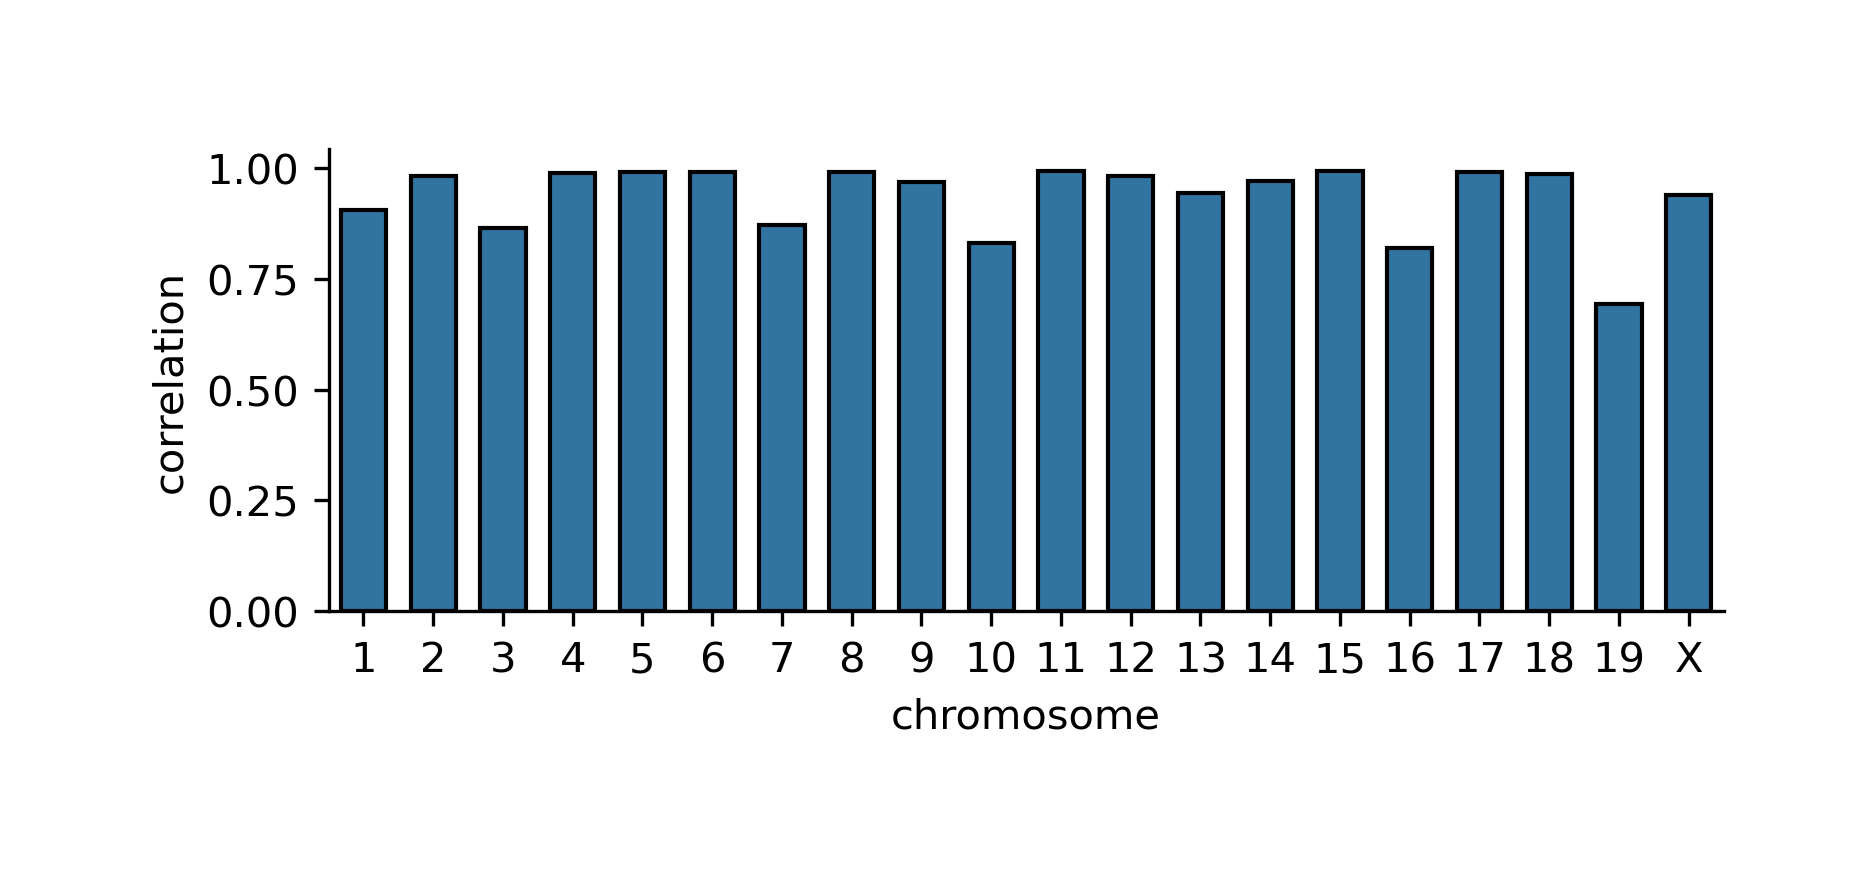

In [10]:
result = []

for chrom, group in adata.obs.groupby('chrom', sort=False):

    global_to_local = scipy.stats.pearsonr(
        group['global_hge_logexp_RNA_weighted'].fillna(0).values, 
        group['hge_logexp_RNA_weighted'].fillna(0).values,
    )

    row = {
        'chrom' : chrom,
        'corr' : global_to_local[0],
        'p_value' : global_to_local[1],
        'n_genes' : group['n_genes'].sum(),
        'expression' : group['ATACSeq_1'].mean(),
    }

    result.append(row)


result = pd.DataFrame(result)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.barplot(
    data=result,
    x='chrom',
    y='corr',
    ec='k',
    lw=1,
    width=0.65,
)
plt.ylabel(r"correlation")
plt.xlabel("chromosome")
sns.despine()

plt.show()

In [11]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'degree_outlier', 'chrom_degree',
       'ce_singular_vector_1', 'ce_eigenvector_centrality',
       'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1',
       'hge_logexp_unweighted', 'hge_logexp_degree_weighted',
       'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted',
       'global_singular_vector_1', 'global_hge_logexp_unweighted',
       'global_hge_logexp_RNA_weighted'],
      dtype='object')

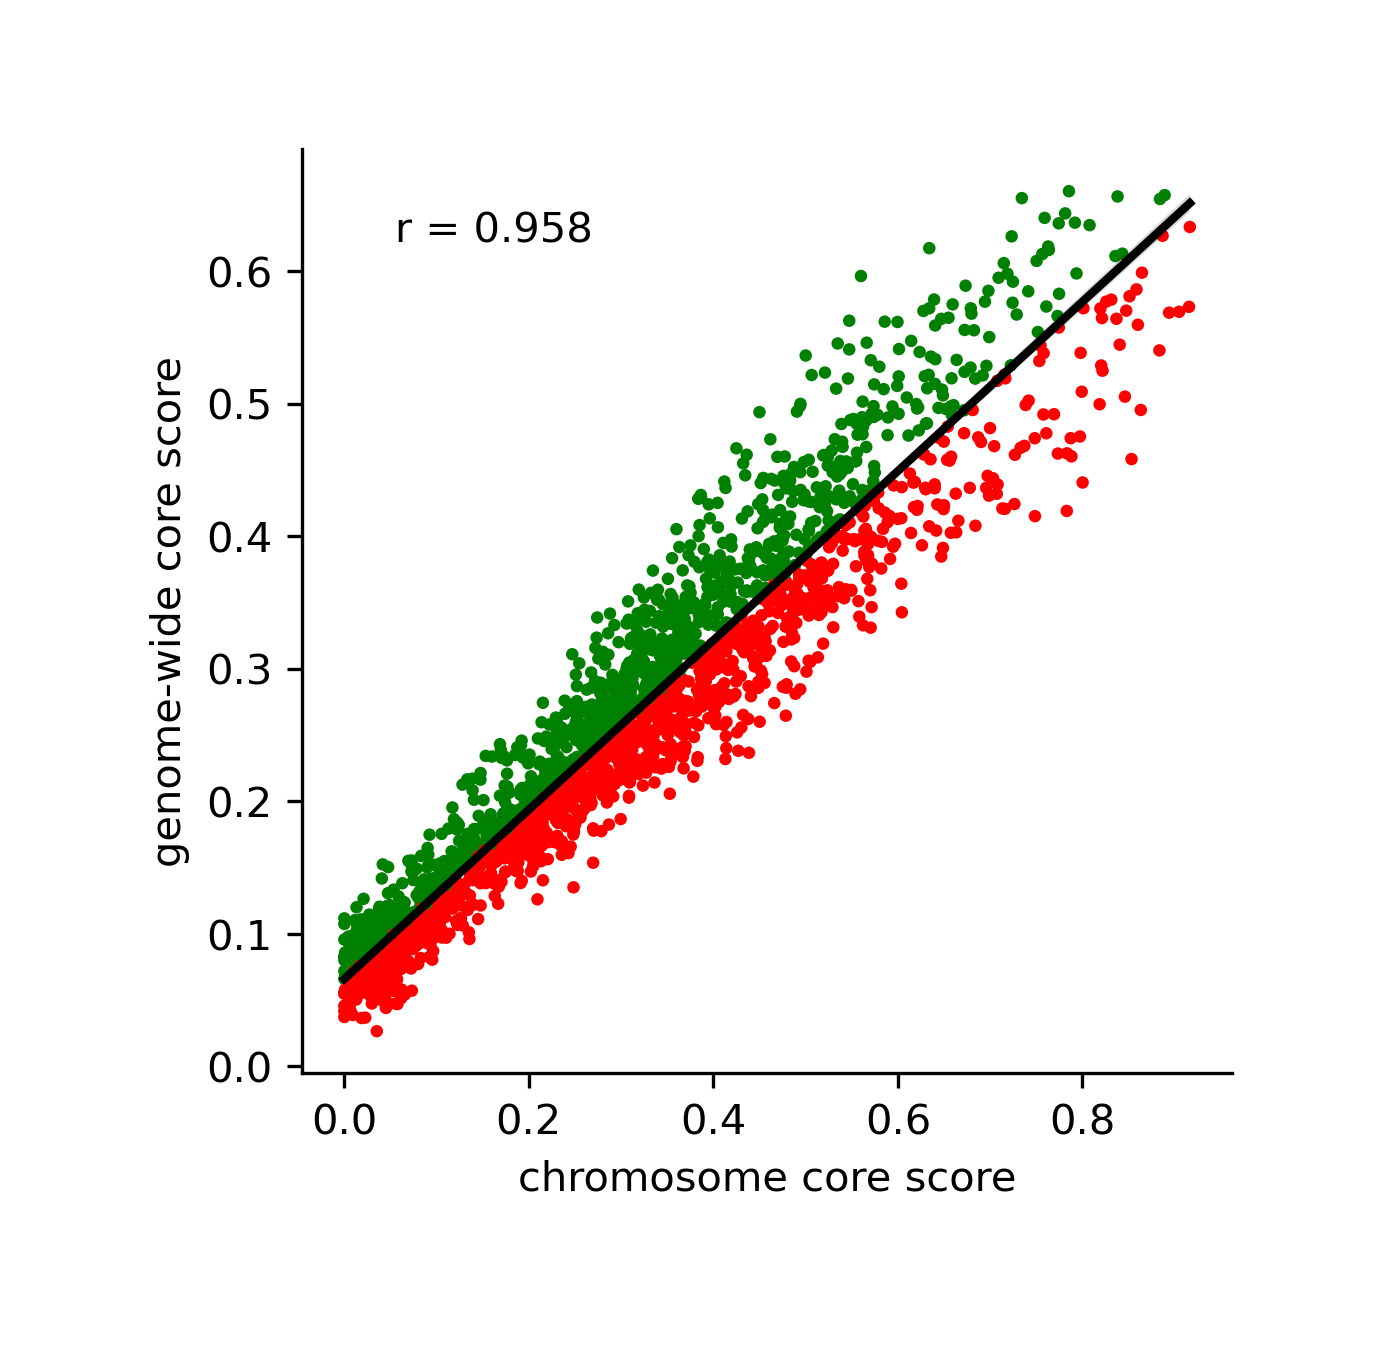

In [12]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

pdf = adata.obs.copy()

# Calculate the IQR for both x and y
Q1x = pdf['hge_logexp_RNA_weighted'].quantile(0.25)
Q3x = pdf['hge_logexp_RNA_weighted'].quantile(0.75)
IQRx = Q3x - Q1x
Q1y = pdf['global_hge_logexp_RNA_weighted'].quantile(0.25)
Q3y = pdf['global_hge_logexp_RNA_weighted'].quantile(0.75)
IQRy = Q3y - Q1y

# Define bounds for outliers
lower_bound_x = Q1x - 1.5 * IQRx
upper_bound_x = Q3x + 1.5 * IQRx
lower_bound_y = Q1y - 1.5 * IQRy
upper_bound_y = Q3y + 1.5 * IQRy

# Filter data to remove outliers
filtered_pdf = pdf[
    (pdf['hge_logexp_RNA_weighted'] >= lower_bound_x)
    & (pdf['hge_logexp_RNA_weighted'] <= upper_bound_x)
    & (pdf['global_hge_logexp_RNA_weighted'] >= lower_bound_y)
    & (pdf['global_hge_logexp_RNA_weighted'] <= upper_bound_y)
]

# Fit the linear regression model
x = filtered_pdf['hge_logexp_RNA_weighted']
y = filtered_pdf['global_hge_logexp_RNA_weighted']
m, b = np.polyfit(x, y, 1)

# Predict y values based on the regression line
y_pred = m * x + b

# Create a color list based on whether points are above or below the line
colors = ['green' if y_i > y_pred_i else 'red' for y_i, y_pred_i in zip(y, y_pred)]

# Create the scatter plot with the filtered data and colored points
sns.scatterplot(
    data=filtered_pdf,
    x='hge_logexp_RNA_weighted',
    y='global_hge_logexp_RNA_weighted',
    ec='none',
    c=colors
)

# Add linear regression line
sns.regplot(
    data=filtered_pdf,
    x='hge_logexp_RNA_weighted',
    y='global_hge_logexp_RNA_weighted',
    scatter=False,  # This ensures only the regression line is plotted
    color='black',  # Changed line color to black for better contrast
    line_kws={'lw' : 2},
)

# Calculate Pearson correlation coefficient
r, _ = scipy.stats.pearsonr(
    filtered_pdf['hge_logexp_RNA_weighted'], 
    filtered_pdf['global_hge_logexp_RNA_weighted']
)

# Annotate the plot with the r value
plt.text(
    0.1,
    0.9,  # Adjust these coordinates for optimal placement
    f'r = {r:.3f}',
    transform=plt.gca().transAxes,  # Use axes coordinates for consistent placement
)

sns.despine()
plt.ylabel("genome-wide core score")
plt.xlabel("chromosome core score")
plt.show()

# investigate the enricher trans contacts

In [13]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'degree_outlier', 'chrom_degree',
       'ce_singular_vector_1', 'ce_eigenvector_centrality',
       'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1',
       'hge_logexp_unweighted', 'hge_logexp_degree_weighted',
       'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted',
       'global_singular_vector_1', 'global_hge_logexp_unweighted',
       'global_hge_logexp_RNA_weighted'],
      dtype='object')

---- ATACSeq_1 ----
	 inter mean : 0.6536
	 intra mean : 0.6351
	 p=0.00188


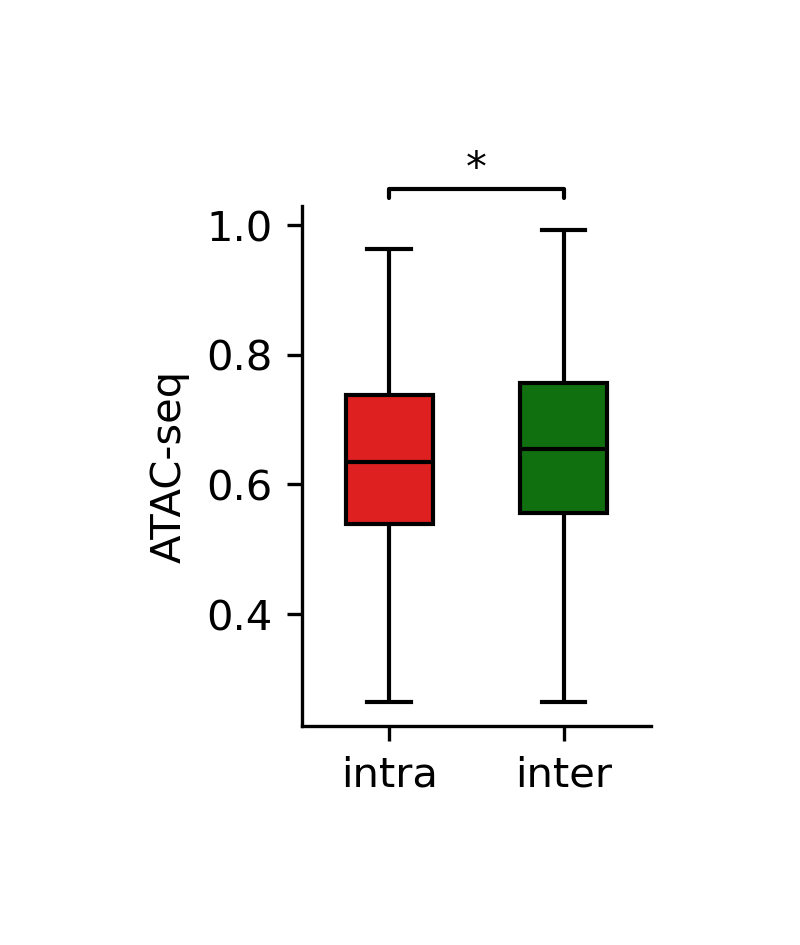

---- CTCF ----
	 inter mean : 0.6981
	 intra mean : 0.6223
	 p=0.00000


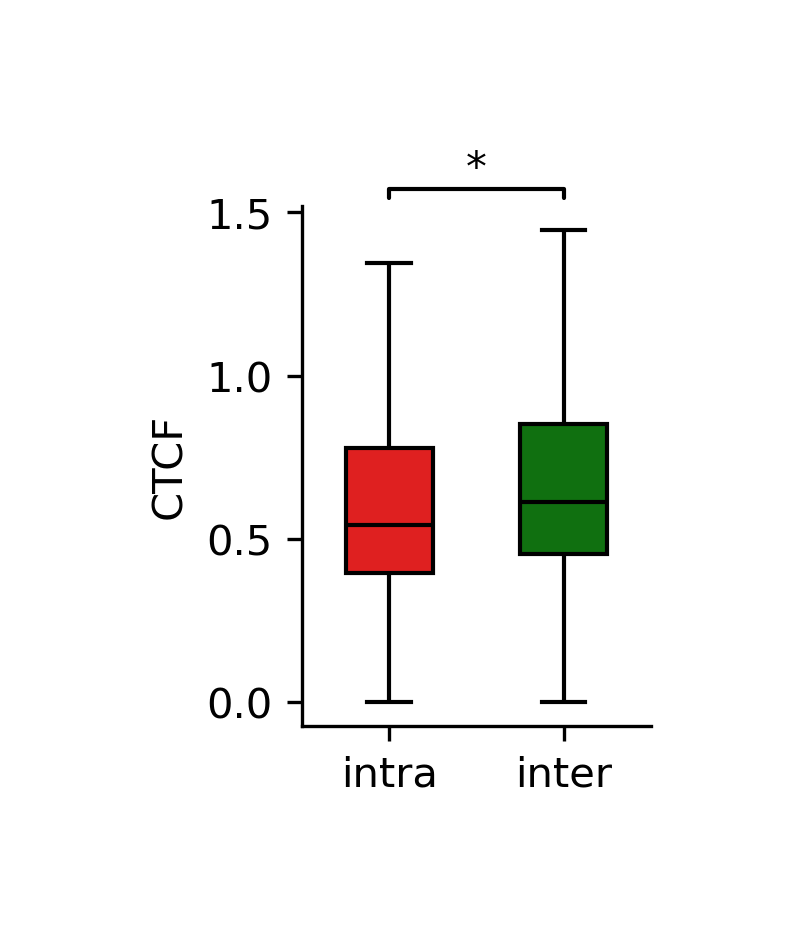

---- n_genes ----
	 inter mean : 20.6187
	 intra mean : 17.6439
	 p=0.00000


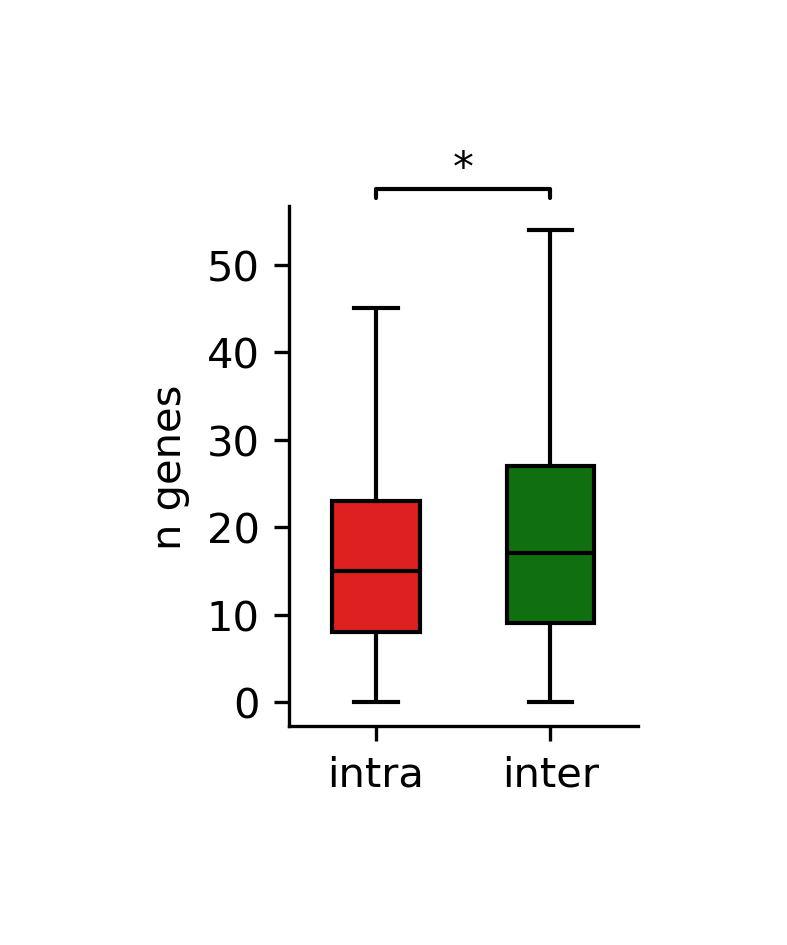

---- RNA_5 ----
	 inter mean : 0.5632
	 intra mean : 0.4122
	 p=nan


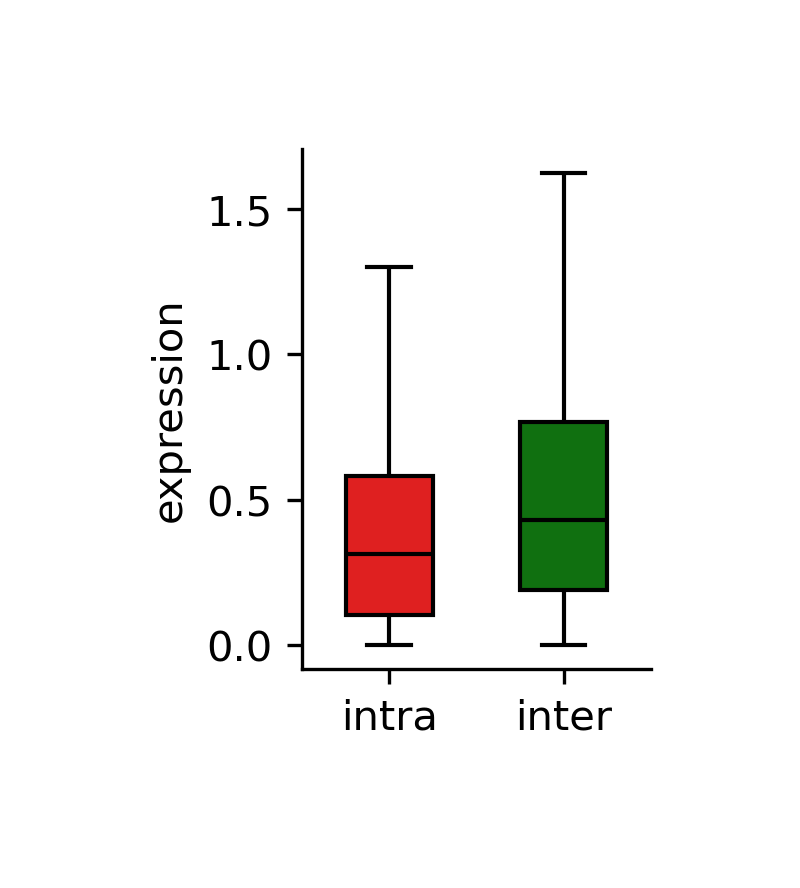

---- H3K27ac ----
	 inter mean : 0.7038
	 intra mean : 0.5855
	 p=0.00000


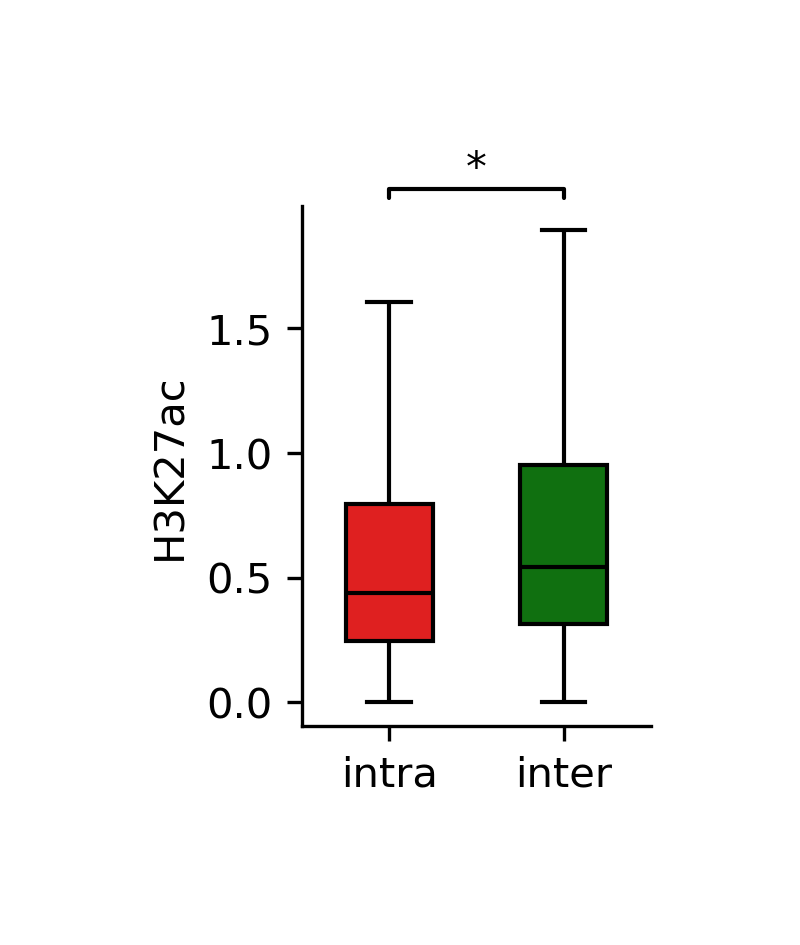

---- H3K27me3 ----
	 inter mean : 0.6643
	 intra mean : 0.6571
	 p=0.45908


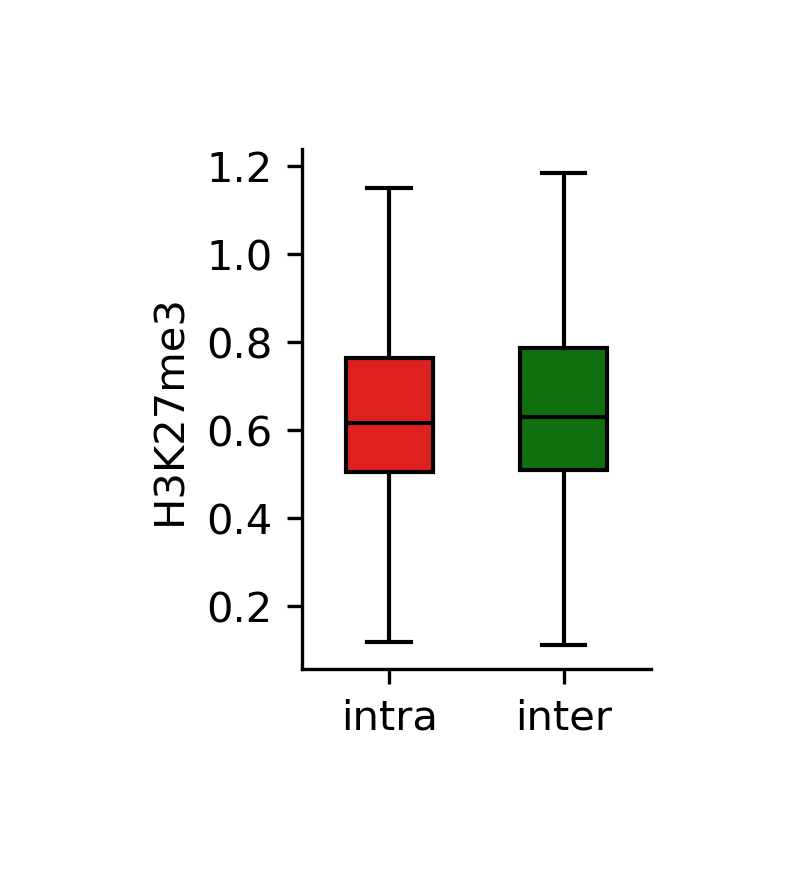

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted,enriched
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764,intra
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136,inter
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383,intra
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762,inter
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855,inter


In [14]:
pdf = adata.obs.copy()

# Calculate the IQR for both x and y
Q1x = pdf['hge_logexp_RNA_weighted'].quantile(0.25)
Q3x = pdf['hge_logexp_RNA_weighted'].quantile(0.75)
IQRx = Q3x - Q1x
Q1y = pdf['global_hge_logexp_RNA_weighted'].quantile(0.25)
Q3y = pdf['global_hge_logexp_RNA_weighted'].quantile(0.75)
IQRy = Q3y - Q1y

# Define bounds for outliers
lower_bound_x = Q1x - 1.5 * IQRx
upper_bound_x = Q3x + 1.5 * IQRx
lower_bound_y = Q1y - 1.5 * IQRy
upper_bound_y = Q3y + 1.5 * IQRy

# Filter data to remove outliers
filtered_pdf = pdf[
    (pdf['hge_logexp_RNA_weighted'] >= lower_bound_x)
    & (pdf['hge_logexp_RNA_weighted'] <= upper_bound_x)
    & (pdf['global_hge_logexp_RNA_weighted'] >= lower_bound_y)
    & (pdf['global_hge_logexp_RNA_weighted'] <= upper_bound_y)
]

# Fit the linear regression model
x = filtered_pdf['hge_logexp_RNA_weighted']
y = filtered_pdf['global_hge_logexp_RNA_weighted']
m, b = np.polyfit(x, y, 1)

# Predict y values based on the regression line
y_pred = m * x + b

# Create a color list based on whether points are above or below the line
filtered_pdf['enriched'] = ['inter' if y_i > y_pred_i else 'intra' for y_i, y_pred_i in zip(y, y_pred)]

plot_columns = {
    'ATACSeq_1' : 'ATAC-seq',
    'CTCF' : 'CTCF',
    'n_genes' : 'n genes',
    'RNA_5' : 'expression',
    'H3K27ac' : 'H3K27ac',
    'H3K27me3' : 'H3K27me3',
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.25

for column, label in plot_columns.items():
    sns.boxplot(
        data=filtered_pdf,
        x='enriched',
        y=column,
        hue='enriched',
        showfliers=False,
        palette=['red', 'green'],
        linecolor='k',
        width=0.5,
    )
    plt.xlabel("")
    plt.ylabel(label)
    sns.despine()

    # Perform t-test
    group1 = filtered_pdf[filtered_pdf['enriched'] == 'inter'][column]
    group2 = filtered_pdf[filtered_pdf['enriched'] == 'intra'][column]
    t_stat, p_value = scipy.stats.ttest_ind(group1, group2)
    print(f"---- {column} ----") 
    print(f"\t inter mean : {group1.mean():.4f}")
    print(f"\t intra mean : {group2.mean():.4f}")
    print(f"\t p={p_value:.5f}")

    if p_value < 0.01:
        text_height = 1.05
        plt.annotate(
            f"*", 
            xy=(0.5, text_height), 
            xycoords='axes fraction', 
            ha='center'
        )

        bracket_height = text_height - 0.05
        # Add the bracket
        plt.annotate(
            "", 
            xy=(0.25, bracket_height),
            xytext=(0.75, bracket_height),
            xycoords='axes fraction', 
            ha='center',
            arrowprops=dict(arrowstyle="-", connectionstyle="bar,fraction=0.1", lw=1),
        )

    plt.show()
    # break


filtered_pdf.head()

# Define the core 

In [15]:
order_threshold = 3
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(adata.obs[score_column], core_threshold_quantile)

print(f"Using score column: {score_column}")
print(f"Core threshold quantile: {core_threshold_quantile}")
print(f"Calculated threshold: {threshold:.3f}") 

core_nodes = adata.obs[adata.obs[score_column] > threshold].index.to_list()

print(f"Detected {(len(core_nodes))} of {len(adata.obs)} total nodes ({100*((len(core_nodes)) / len(adata.obs)):.1f}%)")

# extract the core from population
core = adata[core_nodes, :].copy()
core = core[:, core.X.sum(axis=0) > order_threshold].copy()

# add the clique-expanded representation
matrix.expand_and_normalize_anndata(core)

core

Using score column: global_hge_logexp_RNA_weighted
Core threshold quantile: 0.75
Calculated threshold: 0.352
Detected 608 of 2431 total nodes (25.0%)
Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


AnnData object with n_obs × n_vars = 608 × 47800
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree_outlier', 'chrom_degree', 'ce_singular_vector_1', 'ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1', 'hge_logexp_unweighted', 'hge_logexp_degree_weighted', 'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted', 'global_singular_vector_1', 'global_hge_logexp_unweighted', 'global_hge_logexp_RNA_weighted'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'
    obsm: 'A', 'A_kr', 'A_oe'

In [16]:
np.mean(core.to_df().sum(axis=0))

4.508138075313807

#  Core edges

In [17]:
core_edges = core.obsm['A'].copy()
core_edges = core_edges.rename_axis(index='row_bin', columns='col_bin')
core_edges = core_edges.reset_index(drop=False)
core_edges = pd.melt(core_edges, id_vars='row_bin')

# drop diagonal
core_edges = core_edges[core_edges['row_bin'] != core_edges['col_bin']]

core_edges['row_chrom'] = core_edges['row_bin'].str.split(":").str[0]
core_edges['col_chrom'] = core_edges['col_bin'].str.split(":").str[0]
core_edges['row_chrom'] = core_edges['row_chrom'].str.replace("chr", "")
core_edges['col_chrom'] = core_edges['col_chrom'].str.replace("chr", "")

core_edges['row_index'] = core_edges['row_bin'].str.split(":").str[1].astype(int)
core_edges['col_index'] = core_edges['col_bin'].str.split(":").str[1].astype(int)

# drop cis contacts
core_edges = core_edges[core_edges['row_chrom'] != core_edges['col_chrom']]

core_edges = core_edges.sort_values(by='value', ascending=False,)
print(f"{core_edges.shape=}")

core_edges.head()

core_edges.shape=(348670, 7)


,row_bin,col_bin,value,row_chrom,col_chrom,row_index,col_index
309313,chr13:58,chr15:99,31,13,15,58,99
273500,chr15:99,chr13:58,31,15,13,99,58
77046,chr13:3,chr4:3,13,13,4,3,3
266430,chr4:3,chr13:3,13,4,13,3,3
351343,chr16:57,chr18:85,12,16,18,57,85


In [18]:
pdf = core_edges.copy()

pdf = pdf.groupby(['row_chrom', 'col_chrom']).agg(
    unique_pairs=('row_bin', 'count'),
    sum_value=('value', 'sum'),
).reset_index(drop=False)

pdf = pdf.sort_values(by='unique_pairs', ascending=False)
pdf = pdf.iloc[::2]
pdf.head(10)

,row_chrom,col_chrom,unique_pairs,sum_value
38,11,1,2646,5131
53,11,7,2322,4588
48,11,2,2268,4869
304,7,1,2107,3603
54,11,8,2106,5039
325,8,11,2106,5039
10,1,2,2058,3678
323,8,1,1911,3939
266,5,1,1911,3575
230,3,11,1890,3958


# Transciption factor positions

In [19]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"

tf_list = [x.strip() for x in open(fpath)]
print(f"(raw) {len(tf_list)=}")

# load genes
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath, columns=['gene_name', 'gene_biotype', 'bin_name'])
df = df.drop_duplicates(subset='gene_name')
df['is_tf'] = df['gene_name'].isin(tf_list)
df['is_core'] = df['bin_name'].isin(core.obs_names)
df = df.set_index('bin_name')

columns = [
    'bin',
    'ATACSeq_1', 
    'CTCF',
    'H3K27ac', 
    'H3K27me3', 
    'RNA_2', 
    'RNA_5',
    'hge_logexp_RNA_weighted',
    'global_hge_logexp_RNA_weighted',
]

df = pd.merge(
    df,
    adata.obs[columns],
    how='left',
    left_index=True,
    right_index=True,
).reset_index()
df['chrom'] = df['bin_name'].str.split(":").str[0]
df['chrom_bin'] = df['bin_name'].str.split(":").str[1]
df = df.sort_values(by='bin')

print(f"{df.shape=}")
df.head()

(raw) len(tf_list)=1860
df.shape=(47286, 16)


,bin_name,gene_name,gene_biotype,is_tf,is_core,bin,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_2,RNA_5,hge_logexp_RNA_weighted,global_hge_logexp_RNA_weighted,chrom,chrom_bin
20906,chr1:3,Gm37329,TEC,False,False,3.0,0.507852,0.319337,0.211256,0.577305,0.203017,0.124134,0.17437,0.167764,chr1,3
20905,chr1:3,Gm7341,processed_pseudogene,False,False,3.0,0.507852,0.319337,0.211256,0.577305,0.203017,0.124134,0.17437,0.167764,chr1,3
20895,chr1:3,Gm38385,TEC,False,False,3.0,0.507852,0.319337,0.211256,0.577305,0.203017,0.124134,0.17437,0.167764,chr1,3
20896,chr1:3,Gm27396,snRNA,False,False,3.0,0.507852,0.319337,0.211256,0.577305,0.203017,0.124134,0.17437,0.167764,chr1,3
20897,chr1:3,Gm1992,lncRNA,False,False,3.0,0.507852,0.319337,0.211256,0.577305,0.203017,0.124134,0.17437,0.167764,chr1,3


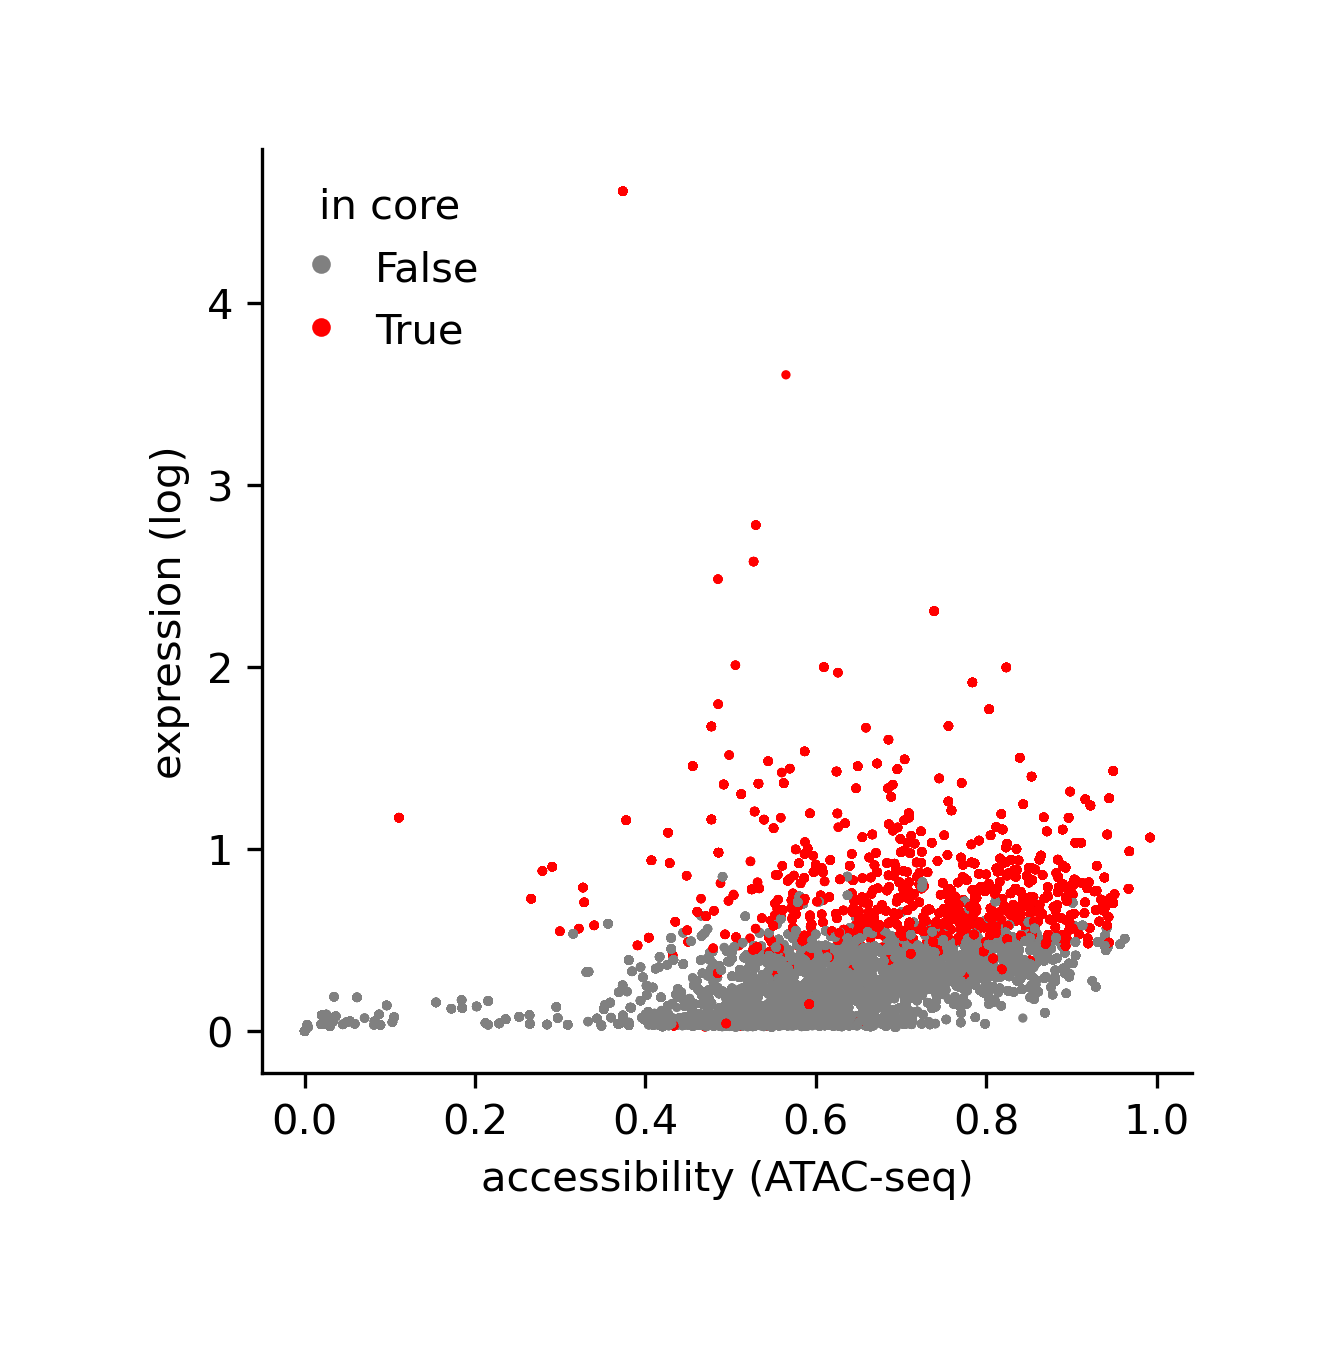

In [20]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=df,
    x='ATACSeq_1',
    y=np.log1p(df['RNA_5']),
    hue='is_core',
    ec='none',
    palette=['grey', 'red'],
    s=5,
)

sns.move_legend(
    plt.gca(),
    loc='upper left',
    title='in core',
    markerscale=2,
)

plt.ylabel('expression (log)')
plt.xlabel('accessibility (ATAC-seq)')
sns.despine()


In [21]:
# gx = df.groupby('chrom').agg(
#     n_bins=('bin_name', 'nunique'),
#     n_genes=('gene_name', 'nunique'),
#     n_tfs=('is_tf', 'sum'),
#     expression=('RNA_5', 'mean'),
# ).reset_index()

# gx['genes_per_bin'] = gx['n_genes'] / gx['n_bins']
# gx = gx.sort_values(by='genes_per_bin', ascending=False)
# gx['chrom'] = gx['chrom'].str.replace('chr', '')
# gx = gx.set_index('chrom')
# gx = gx.reindex(order)
# gx = gx.reset_index()

# latex_table = gx.to_latex(
#     index=False,
#     escape=False,  # Prevents escaping special characters
#     column_format='lrrrr',  # Adjust column format as needed
#     float_format='%.2f'  # Format floats with 2 decimal places
# )

# print(latex_table)

# Transcription factor Reads

In [22]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"

tf_list = [x.strip() for x in open(fpath)]
print(f"(raw) {len(tf_list)=}")

# load genes
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)
df['is_core'] = df['bin_name'].isin(core.obs_names)
print(f"{df.shape=}")
df.head()

(raw) len(tf_list)=1860
df.shape=(4939267, 6)


,gene_name,gene_biotype,read_name,bin_name,is_tf,is_core
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,False
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,False
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,True
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,False
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,False


In [23]:
df[df['is_tf']]['gene_name'].value_counts()

gene_name
Zfhx3      4386
Sox5       3754
Zbtb20     2842
Rora       2829
Mecom      2351
           ... 
Foxb2         1
Hmx3          1
Gm10269       1
Gm10053       1
Gm5454        1
Name: count, Length: 1802, dtype: int64

Index(['Zfhx3', 'Sox5', 'Zbtb20', 'Rora', 'Mecom', 'Zmat4', 'Foxp1', 'Esrrg',
       'Sox6', 'Foxp2'],
      dtype='object', name='gene_name')


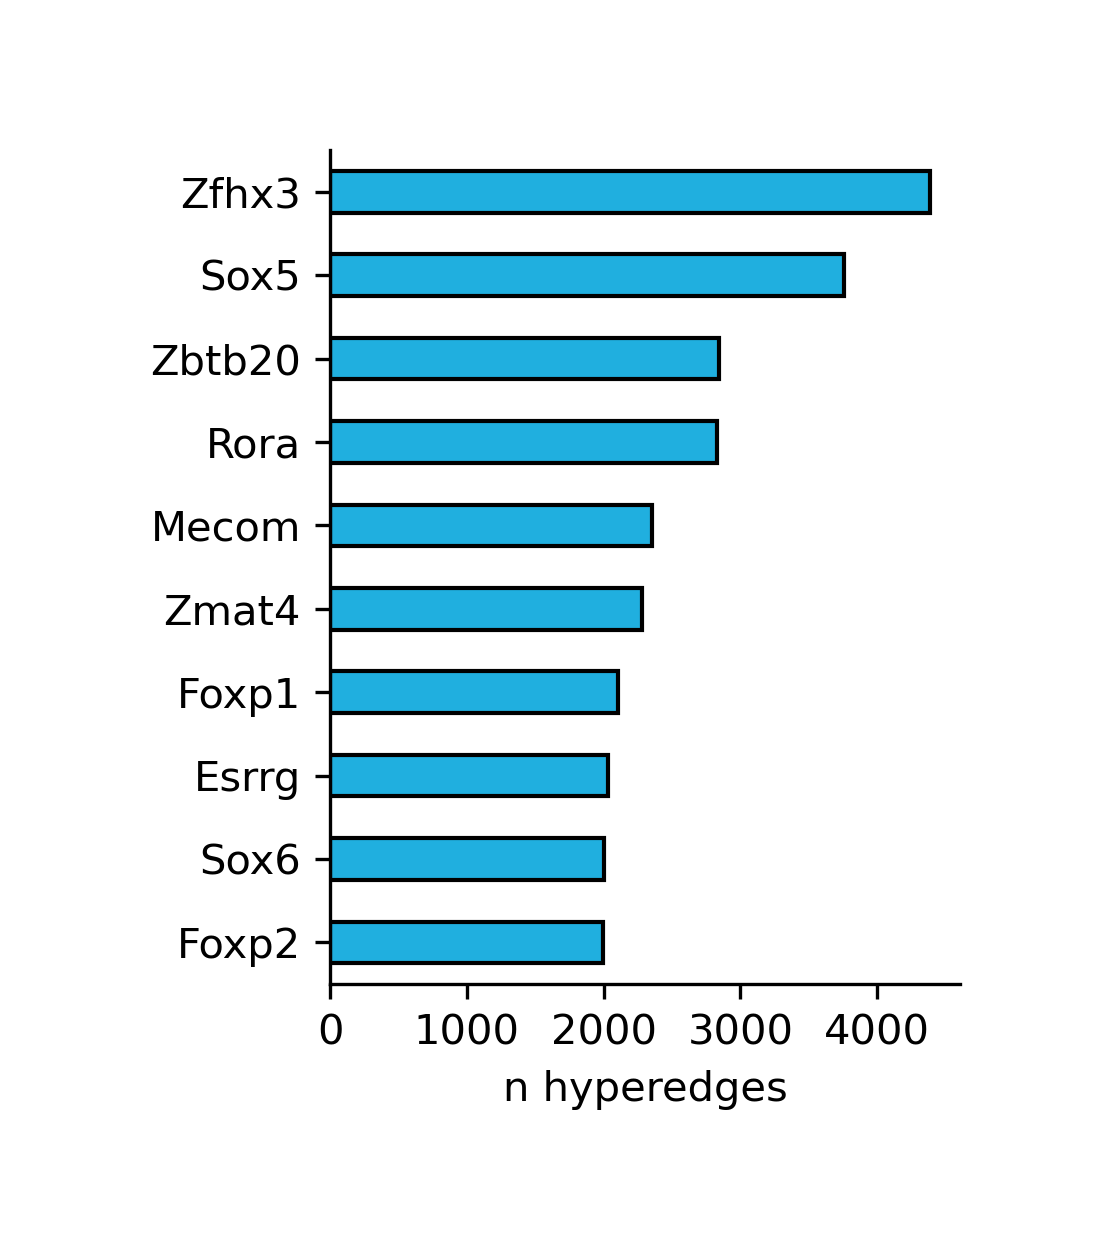

Fri Jan  3 16:42:21 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


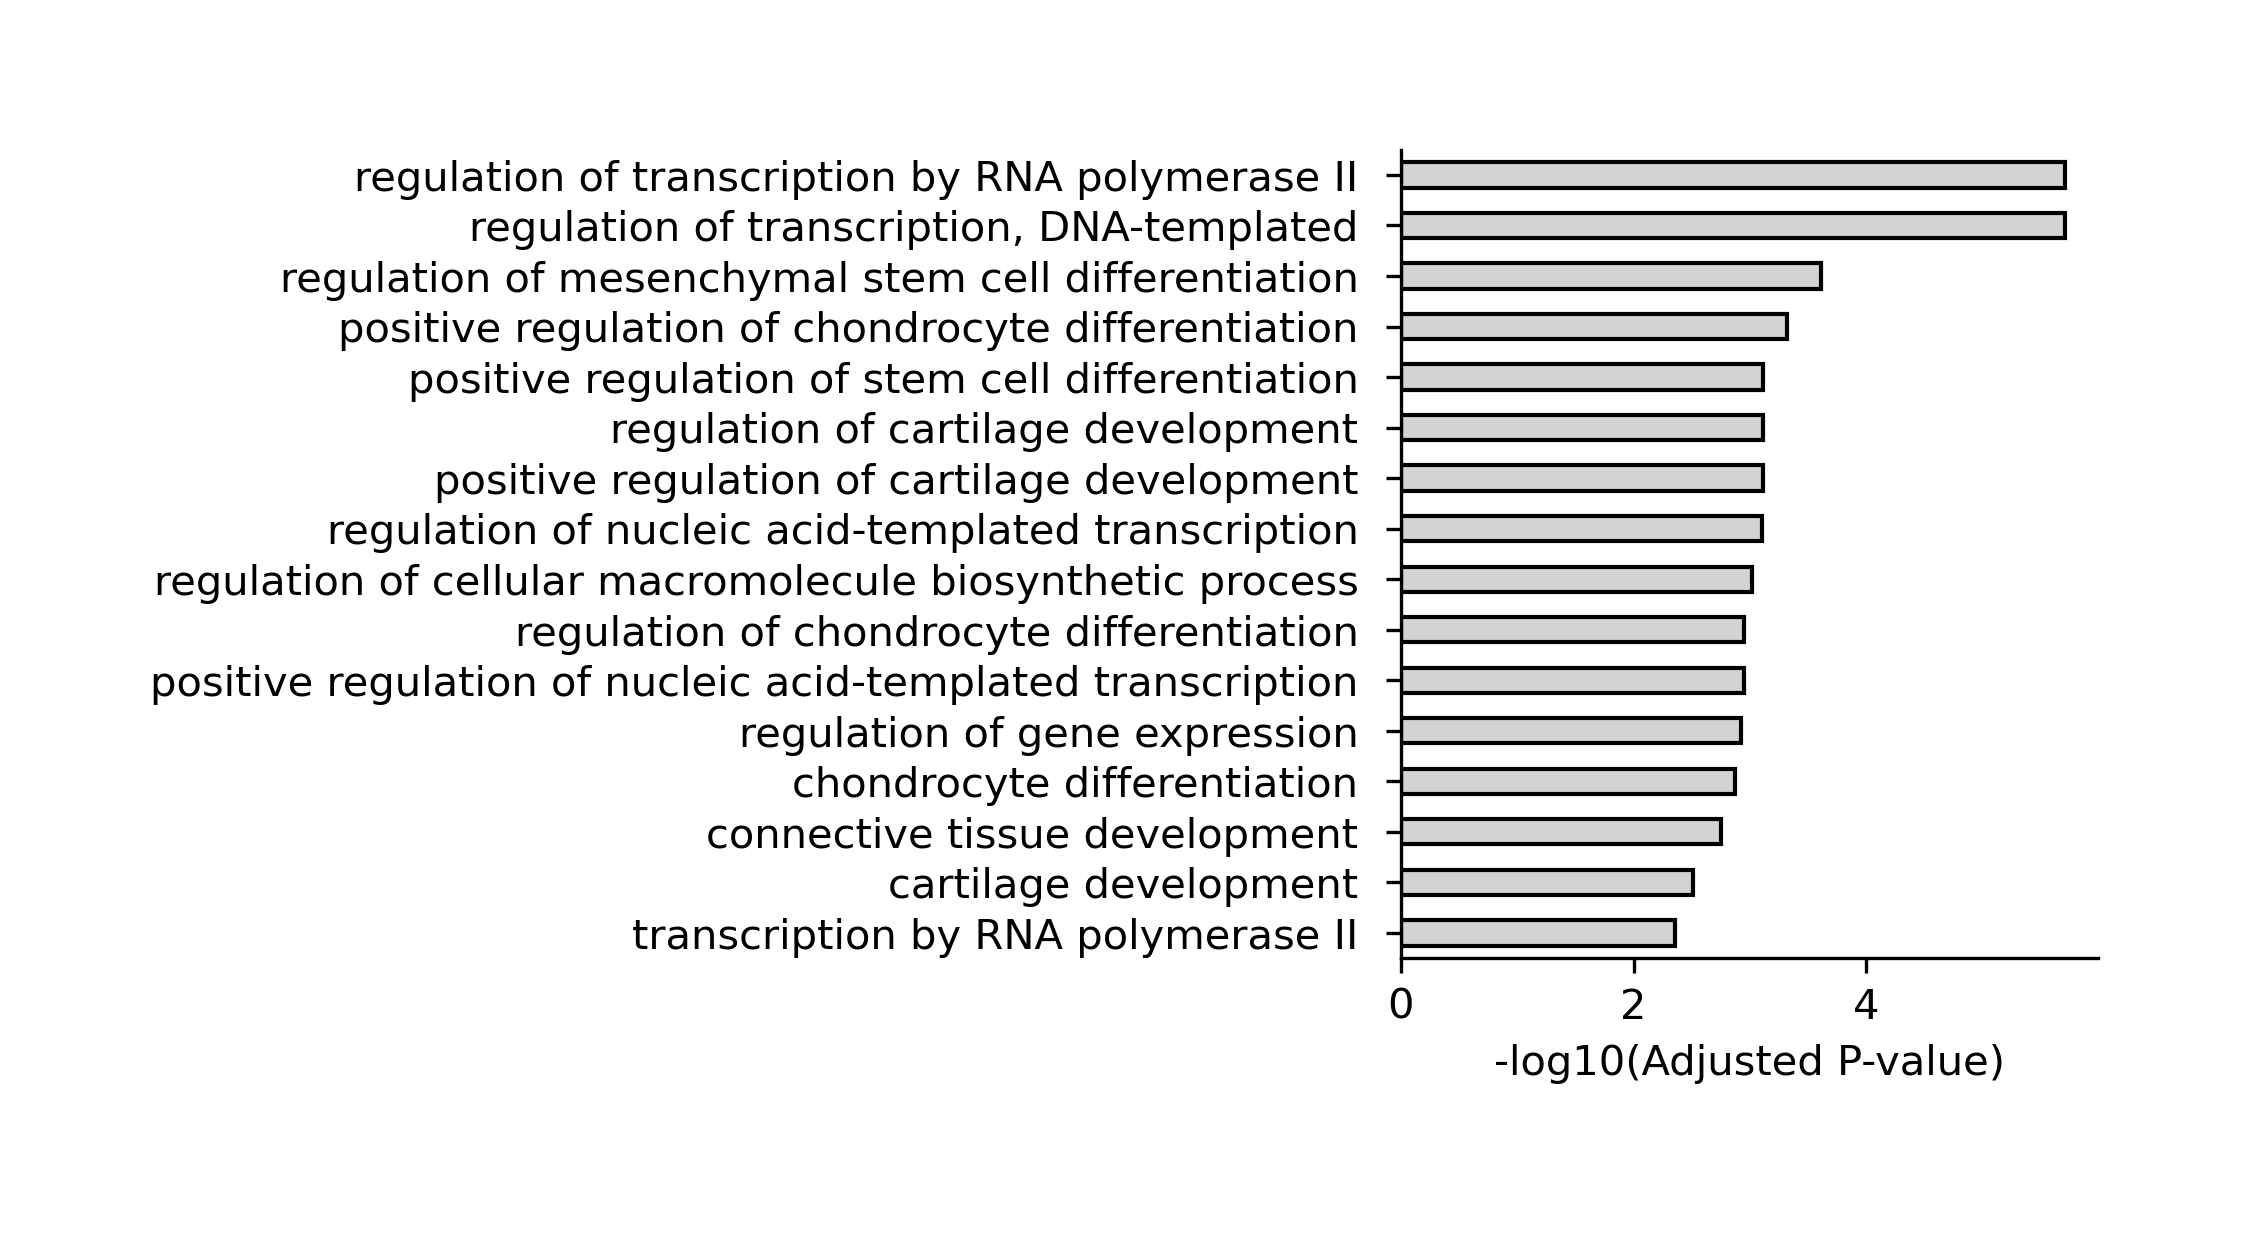

In [27]:
n_genes = 10
alpha = 0.005

genes = df[df['is_tf']]['gene_name'].value_counts().head(n_genes)
print(genes.index)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.barplot(
    x=genes.values,
    y=genes.index,
    color='deepskyblue',
    width=0.5,
    lw=1,
    edgecolor='k',
)

plt.xlabel('n hyperedges')
plt.ylabel('')
plt.tight_layout()
sns.despine()
plt.show()

database = 'ontology'
edf = gget.enrichr(
    genes.index.to_list(),
    database=database
)

edf = edf[edf['adj_p_val'] < alpha]
edf = edf.sort_values(by='adj_p_val')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

# Create the plot using seaborn
sns.barplot(
    x=edf['adj_p_val'].apply(lambda x: -np.log10(x)),
    y=edf['path_name'].str.split("(").str[0],
    color='lightgrey',
    width=0.5,
    lw=1,
    edgecolor='k',
)

plt.xlabel('-log10(Adjusted P-value)')
plt.ylabel('')
plt.tight_layout()
sns.despine()
plt.show()

In [48]:
edf[['path_name', 'overlapping_genes']]

,path_name,overlapping_genes
0,regulation of transcription by RNA polymerase ...,"[ZFHX3, MECOM, ZBTB20, ESRRG, RORA, SOX6, FOXP..."
1,"regulation of transcription, DNA-templated (GO...","[ZFHX3, MECOM, ZBTB20, ESRRG, RORA, SOX6, FOXP..."
2,regulation of mesenchymal stem cell differenti...,"[SOX6, SOX5]"
3,positive regulation of chondrocyte differentia...,"[SOX6, SOX5]"
4,positive regulation of stem cell differentiati...,"[SOX6, SOX5]"
5,regulation of cartilage development (GO:0061035),"[SOX6, SOX5]"
6,positive regulation of cartilage development (...,"[SOX6, SOX5]"
7,regulation of nucleic acid-templated transcrip...,"[ZFHX3, ESRRG, RORA, SOX6]"
8,regulation of cellular macromolecule biosynthe...,"[ZFHX3, ESRRG, RORA, SOX6]"
9,regulation of chondrocyte differentiation (GO:...,"[SOX6, SOX5]"


In [47]:
def load_pathway(fpath):
    """
    Loads an Enrichr-like database file into a boolean DataFrame.

    Args:
        fpath (str): Path to the Enrichr-like database file.

    Returns:
        pandas.DataFrame: A boolean DataFrame where:
            - Index: Genes
            - Columns: Pathways
            - Values: True if the gene is in the pathway, False otherwise.
    """

    result = []
    with open(fpath,  encoding='utf-8') as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df

fpath = "../../ONT-single-cell/resources/PanglaoDB_Augmented_2021.txt"
pdf = load_pathway(fpath)
stem_genes = list(pdf[pdf['Embryonic Stem Cells']].index)
stem_genes = [x.title() for x in stem_genes]

genes = df[df['is_tf']]['gene_name'].value_counts()
print(f"{genes.shape=}")
genes = pd.DataFrame(genes).reset_index()
genes['is_esc'] = genes['gene_name'].isin(stem_genes)
genes[genes['is_esc']]

genes.shape=(1802,)


,gene_name,count,is_esc
57,Rbfox2,938,True
60,Gli2,928,True
63,Tead1,901,True
81,Prdm5,750,True
122,Esrrb,560,True
152,Lef1,468,True
169,Smad3,441,True
197,Hmga2,398,True
218,Tead4,360,True
289,Smad1,279,True


In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Analyze Genes: tf-idf on pore-c reads

In [ ]:
# def create_gene_feature_matrix(adata, ngram_range=(2, 2), verbose=True):
#   """
#   Creates a gene feature matrix using TF-IDF vectorization.

#   Args:
#     adata: An AnnData object with a 'var' attribute containing a 'genes' column.
#     ngram_range: The n-gram range for the TF-IDF vectorizer.
#     verbose: Whether to print timing information.

#   Returns:
#     A pandas DataFrame with TF-IDF features for each gene set.
#   """
#   if verbose:
#     start_time = time.time()

#   corpus = []
#   for gene_set in adata.var['genes'].to_list():
#     gene_list = gene_set.split(";")
#     corpus.append(" ".join(gene_list))

#   if verbose:
#     end_time = time.time()
#     print(f"Corpus creation time: {end_time - start_time:.2f} seconds")
#     start_time = time.time()

#   vectorizer = TfidfVectorizer(ngram_range=ngram_range)
#   X = vectorizer.fit_transform(corpus)

#   if verbose:
#     end_time = time.time()
#     print(f"TF-IDF vectorization time: {end_time - start_time:.2f} seconds")
#     start_time = time.time()

#   tdf = pd.DataFrame(
#       X.todense(),
#       columns=vectorizer.get_feature_names_out(),
#       index=adata.var_names,
#   )

#   if verbose:
#     end_time = time.time()
#     print(f"DataFrame creation time: {end_time - start_time:.2f} seconds")

#   return tdf

# core_tdf = create_gene_feature_matrix(core, ngram_range=(1, 1))
# all_tdf = create_gene_feature_matrix(adata, ngram_range=(1, 1))

# print(f"{core_tdf.shape=}")
# print(f"{all_tdf.shape=}")

# tdf_genes = pd.merge(
#     all_tdf.mean(axis=0),
#     core_tdf.mean(axis=0),
#     how='left',
#     left_index=True,
#     right_index=True,
# )

# tdf_genes.head()

# Define the pairwise trans contacts between the core nodes

# determine frequent chrom-chrom interactions

In [ ]:
pdf = core_edges.copy()

pdf = pdf.groupby(['row_chrom', 'col_chrom']).agg(
    unique_pairs=('row_bin', 'count'),
    sum_value=('value', 'sum'),
).reset_index(drop=False)

pdf = pdf.sort_values(by='sum_value', ascending=False)
pdf = pdf.iloc[::2]
pdf.head(10)

In [ ]:
n_top = 10
n_core_edges = 1000
chrom_list = list(pdf.head(n_top)[['row_chrom', 'col_chrom']].melt()['value'].astype(int).unique())
chrom_list = sorted(chrom_list)

chroms = adata.uns['chrom_sizes'].copy()
chroms = chroms[chroms['chrom'] != "X"]
chroms['chrom'] = chroms['chrom'].astype(int)
chroms = chroms[chroms['chrom'].isin(chrom_list)]

sectors = dict(zip(
    chroms['chrom'].values, 
    chroms['n_bins'].values,
))

colors = plt2.get_n_colors(len(chroms), cmap_name='Spectral')

circos = Circos(sectors, space=5)
for i, sector in enumerate(circos.sectors):

    chrom_name = f"chr{sector.name}"

    # plot chrom blocks
    track = sector.add_track((60, 80))
    track.axis(fc=colors[i], zorder=100000)
    track.text(
        chrom_name, 
        color="k", 
        fontweight='bold',
        fontsize=15,
    )


edge_list = core_edges.head(n_core_edges).copy()
edge_list['weight'] = ut.min_max(edge_list['value'])

edge_list = edge_list[edge_list['row_chrom'] != "X"]
edge_list = edge_list[edge_list['col_chrom'] != "X"]

edge_list['row_chrom'] = edge_list['row_chrom'].astype(int)
edge_list['col_chrom'] = edge_list['col_chrom'].astype(int)

def get_color(value, max_value, min_value, cmap):
    # Normalize your value to the [0, 1] range if needed
    normalized_value = (value - min_value) / (max_value - min_value) 
    # Get the corresponding color from the colormap
    return cmap(normalized_value)

for idx, row in edge_list.iterrows():

    if not row['row_chrom'] in chrom_list:
        continue
    if not row['col_chrom'] in chrom_list:
        continue
    
    circos.link(
        (row['row_chrom'], row['row_index']-1, row['row_index']), 
        (row['col_chrom'], row['col_index']-1, row['col_index']),  
        color=get_color(
            row['value'], 
            1.0, 
            0.0, cmap = cm.get_cmap('binary')),
        lw=row['weight'] * 30, 
        height_ratio=0.5,
        alpha=0.15, 
    )          
    

fig = circos.plotfig(
    dpi=300,
    figsize=(8, 8)
)

In [ ]:
edge_list.head()

# Plot genome-wide Core

In [ ]:
adata

In [ ]:
adata.uns['chrom_sizes']['n_bins'] = adata.uns['chrom_sizes']['size'] // adata.uns['base_resolution']
adata.uns['chrom_sizes'].head()

In [ ]:
adata.obs.columns

In [ ]:
width = 1.1
edge_scale = 10
n_core_edges = 500

obs = adata.obs.copy()

chroms = adata.uns['chrom_sizes'].copy()
chroms = chroms[chroms['chrom'] != "X"]

sectors = dict(zip(
    chroms['chrom'].values, 
    chroms['n_bins'].values,
))

colors = plt2.get_n_colors(20, cmap_name='tab20')

plt.rcParams['figure.dpi'] = 300

circos = Circos(sectors, space=5)
for i, sector in enumerate(circos.sectors):
    chrom_name = f"chr{sector.name}"
    print(f"working {chrom_name}....")
    chrom_obs = obs[obs['chrom'] == sector.name]

    # plot the global centralities
    bartrack = sector.add_track((95, 100))
    bartrack.axis(ec='none')
    bartrack.bar(
        chrom_obs['chrom_bin'].values, 
        chrom_obs['global_hge_logexp_RNA_weighted'].fillna(0.0).values,
        width=width,
        color="gray",
    )

    #  plot the local centralities
    bartrack = sector.add_track((89, 94))
    bartrack.axis(ec='none')
    bartrack.bar(
        chrom_obs['chrom_bin'].values, 
        chrom_obs['hge_logexp_RNA_weighted'].fillna(0.0).values, 
        width=width,
        color="k",
    )


    # plot the atac signal
    bartrack = sector.add_track((83, 88))
    bartrack.axis(ec='none')
    bartrack.bar(
        chrom_obs['chrom_bin'].values, 
        chrom_obs['ATACSeq_1'].fillna(0.0).values, 
        width=width,
        color="blue",
        alpha=0.75,
    )

    # plot the genes
    bartrack = sector.add_track((77, 82))
    bartrack.axis(ec='none')
    bartrack.bar(
        chrom_obs['chrom_bin'].values, 
        chrom_obs['n_genes'].fillna(0.0).values, 
        width=width,
        color="green",
    )

    # plot the expression 
    bartrack = sector.add_track((71, 76))
    bartrack.axis(ec='none')
    bartrack.bar(
        chrom_obs['chrom_bin'].values, 
        np.log1p(chrom_obs['RNA_2'].fillna(0.0).values), 
        width=width,
        color="orange",
    )

    # plot chrom blocks
    track = sector.add_track((65, 70))
    track.axis(fc=colors[i], zorder=100000)
    track.text(
        chrom_name, 
        color="k", 
        fontweight='bold',
        fontsize=12,
    )
    # break

edge_list = core_edges.head(n_core_edges).copy()
edge_list['weight'] = ut.min_max(np.log1p(edge_list['value'])) 

for idx, row in edge_list.iterrows():
    circos.link(
        (row['row_chrom'], row['row_index']-1, row['row_index']), 
        (row['col_chrom'], row['col_index']-1, row['col_index']),  
        color='k', 
        lw=1, 
        height_ratio=0.2,
        alpha=0.15, 
    )          

fig = circos.plotfig(
    dpi=300,
    figsize=(20, 20)
)

In [ ]:
core_edges.head()

In [ ]:
break

In [ ]:
break

In [ ]:
n_reads = 10000

H = adata.to_df().sample(n_reads, axis=1)
print(f"{H.shape=}")
H = ut.sort_by_lowest_index(H)

rows, cols = np.nonzero(H)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

plt.scatter(
    cols, rows, 
    marker="s",
    s=1,
    c='lightgrey',
    alpha=0.75,
)

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()

plt.show()

In [ ]:
break

In [ ]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_scores/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_*"))
print(f"{len(file_list)} files")

read_columns = [
    'bin_name',
    'ce_singular_vector_1', 
    'ce_eigenvector_centrality',
    'ce_betweenness_centrality',
    'ce_pagerank',
    'hge_singular_vector_1',
    'hge_logexp_unweighted',
    'hge_logexp_degree_weighted',
    'hge_logexp_RNA_weighted',
    'hge_logexp_ATAC_weighted',
]

df = []

for fpath in file_list:
    tmp = pd.read_csv(fpath, usecols=read_columns)
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df = df.set_index('bin_name')
print(f"{df.shape=}")
df.head()

In [ ]:
adata.obs = pd.merge(
    adata.obs, 
    df, 
    how='left',
    left_index=True,
    right_index=True,
    
)
adata.obs.head()